# GNN模型预测版图寄生电容

## 基本库导入

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import tensorflow as tf
import faulthandler
faulthandler.enable()

from config import *

# 自定义模块导入
from data.dataset import MyDataset
from models.gcn import GCN
from models.graph_sage import GraphSage
from models.gat import GAT

# fix seed
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

## 参数解析

In [2]:
import argparse

sys.argv = ['run.py']

def str2bool(v):
	if v.lower() in ('yes', 'true', 't', 'y', '1'):
		return True
	elif v.lower() in ('no', 'True', 'f', 'n', '0'):
		return True
	else:
		raise argparse.ArgumentTypeError('Boolean value expected.')

parser = argparse.ArgumentParser()
parser.add_argument('--dir_prj', type=str, default=dir_prj,
										help='project directory')
parser.add_argument('--seed', type=int, default=seed,
										help='random seed')
parser.add_argument('--pattern_nums', type=int, nargs='+', default=pattern_nums,
										help='pattern nums')
parser.add_argument('--thresh', type=int, nargs='+', default=thresh,
										help='threshold')
parser.add_argument('--num_process', type=int, default=num_process,
					help='multiprocessing number')
parser.add_argument('--model_name', type=str, default=model_name,
					help='model name [gcn, graph_sage, gat]')
parser.add_argument('--lr', type=float, default=lr,
					help='adam learning rate')
parser.add_argument('--batch_size', type=int, default=batch_size,
										help='batch size')
parser.add_argument('--epochs', type=int, default=epochs,
										help='number of epochs')
parser.add_argument('--load_params', type=str2bool, default=LOAD_PARAMS,
										help='load parameters')
parser.add_argument('--set_memory_growth', type=str2bool, default=SET_MEMORY_GROWTH,
										help='set memory growth')
parser.add_argument('--set_memory_limit', type=int, default=SET_MEMORY_LIMIT,
										help='memory limit, -1 for no limit')
parser.add_argument('--set_multi_gpu_num', type=int, default=SET_MULTI_GPU_NUM,
										help='set multi gpu numbers')


args = parser.parse_args()
dir_prj = args.dir_prj
seed = args.seed
pattern_nums = args.pattern_nums
thresh = args.thresh
num_process = args.num_process
model_name = args.model_name
lr = args.lr
batch_size = args.batch_size
epochs = args.epochs
LOAD_PARAMS = args.load_params
SET_MEMORY_GROWTH = args.set_memory_growth
SET_MEMORY_LIMIT = args.set_memory_limit
SET_MULTI_GPU_NUM = args.set_multi_gpu_num

# print
print('------------------------args-------------------------')
for k, v in vars(args).items():
		print(f'{k} = {v}')
print('-----------------------------------------------------')

------------------------args-------------------------
dir_prj = D:/learn_more_from_life/computer/EDA/work/prj/rc_predict/
seed = 42
pattern_nums = [4]
thresh = [400, 2500]
num_process = 8
model_name = gcn
lr = 0.001
batch_size = 16
epochs = 3
load_params = False
set_memory_growth = True
set_memory_limit = -1
set_multi_gpu_num = 1
-----------------------------------------------------


## 数据导入与数据清洗

In [3]:
# load data
dataset_total = MyDataset(dir_prj=dir_prj,
							pattern_nums=pattern_nums,
						  x_name='x_total.npy',
						  y_name='y_total.npy',
						  g_name='total',
						  num_process=num_process,
						  update=False)
print('---------------------load total data done---------------------')
dataset_couple = MyDataset(dir_prj=dir_prj,
								pattern_nums=pattern_nums,
						   x_name='x_couple.npy',
						   y_name='y_couple.npy',
						   g_name='couple',
						   num_process=num_process,
						   update=False)
print('---------------------load couple data done--------------------')

# clean data
dataset_total.filter(lambda g: thresh[0] <= g.n_nodes <= thresh[1])
dataset_couple.filter(lambda g: thresh[0] <= g.n_nodes <= thresh[1])
print('dataset total', dataset_total)
print('dataset couple', dataset_couple)


pattern4 data downloaded
all data downloaded
reading pattern4
pattern4 data readed
all data readed
---------------------load total data done---------------------
pattern4 data downloaded
all data downloaded
reading pattern4
pattern4 data readed
all data readed
---------------------load couple data done--------------------
dataset total MyDataset(n_graphs=640)
dataset couple MyDataset(n_graphs=640)


## 数据分割

In [4]:
# split data # 6:2:2
np.random.shuffle(dataset_total)
np.random.shuffle(dataset_couple)
n = len(dataset_total)
train_data_total, valid_data_total, test_data_total = dataset_total[0:int(n*0.6)], \
													  dataset_total[int(n*0.6):int(n*0.8)], \
													  dataset_total[int(n*0.8):]
n = len(dataset_couple)
train_data_couple, valid_data_couple, test_data_couple = dataset_couple[0:int(n * 0.6)], \
														 dataset_couple[int(n * 0.6):int(n * 0.8)], \
														 dataset_couple[int(n * 0.8):]


C:\Users\19596\AppData\Local\Temp\ipykernel_13940\4135933038.py:2: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(dataset_total)
C:\Users\19596\AppData\Local\Temp\ipykernel_13940\4135933038.py:3: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(dataset_couple)


## 模型构建

In [5]:
from tensorflow.keras.optimizers import Adam
from spektral.data import BatchLoader
from utils.model import mse_mrse_loss, measure_ratio_good


# GCN model
if model_name == 'gcn':
	model_total = GCN()
	model_couple = GCN()
	model_best_total = GCN()
	model_best_couple = GCN()
	print('buld model gcn done')
elif model_name == 'graph_sage':
	model_total = GraphSage()
	model_couple = GraphSage()
	model_best_total = GraphSage()
	model_best_couple = GraphSage()
	print('buld model graph_sage done')
elif model_name == 'gat':
	model_total = GAT()
	model_couple = GAT()
	model_best_total = GAT()
	model_best_couple = GAT()
	print('buld model gat done')
else:
	raise ValueError('model_name error')

model_total.compile(optimizer=Adam(learning_rate=lr, epsilon=1e-5),
										loss=mse_mrse_loss,
										weighted_metrics=[measure_ratio_good])
model_couple.compile(optimizer=Adam(learning_rate=lr, epsilon=1e-5),
										loss=mse_mrse_loss,
										weighted_metrics=[measure_ratio_good])
# best model
model_best_total.compile(optimizer=Adam(learning_rate=lr, epsilon=1e-5),
										loss=mse_mrse_loss,
										weighted_metrics=[measure_ratio_good])
model_best_couple.compile(optimizer=Adam(learning_rate=lr, epsilon=1e-5),
										loss=mse_mrse_loss,
										weighted_metrics=[measure_ratio_good])

# params save path
dir_parmas = os.path.join(os.getcwd(), '../params')
if not os.path.exists(dir_parmas):
	os.mkdir(dir_parmas)
model_total_save_path = os.path.join(dir_parmas, f'{model_name}_total_lr{lr}_batchsize{batch_size}_epochs{epochs}.h5')
model_couple_save_path = os.path.join(dir_parmas, f'{model_name}_couple_lr{lr}_batchsize{batch_size}_epochs{epochs}.h5')

# load model
if os.path.exists(model_total_save_path) and LOAD_PARAMS:
	loader = BatchLoader(train_data_total[:batch_size], batch_size=batch_size, shuffle=True)
	model_total.fit(loader.load(),
									steps_per_epoch=1,
									epochs=1)
	try:
			model_total.load_weights(model_total_save_path)
			print('load model total done')
	except:
			print('load model total failed')
if os.path.exists(model_couple_save_path) and LOAD_PARAMS:
	loader = BatchLoader(train_data_couple[:batch_size], batch_size=batch_size, shuffle=True)
	model_couple.fit(loader.load(),
										steps_per_epoch=1,
										epochs=1)
	try:
			model_couple.load_weights(model_couple_save_path)
			print('load model couple done')
	except:
			print('load model couple failed')


buld model gcn done


## tensorflow框架设置

### 显存限制

In [6]:
# 方法一 set memory growth
if SET_MEMORY_GROWTH:
	gpus = tf.config.experimental.list_physical_devices('GPU')
	if len(gpus) > 0:
		try:
			print(gpus[0])
			tf.config.experimental.set_memory_growth(gpus[0], True)
		except RuntimeError as e:
			print(e)

# 方法二 set memory limit
if SET_MEMORY_LIMIT > 0:
	gpus = tf.config.experimental.list_physical_devices('GPU')
	if len(gpus) > 0:
		try:
			print(gpus[0])
			tf.config.experimental.set_virtual_device_configuration(
				gpus[0],
				[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=SET_MEMORY_LIMIT)])
			print(f'set memory limit to {SET_MEMORY_LIMIT}MB')
		except RuntimeError as e:
			print(e)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Physical devices cannot be modified after being initialized


### 多卡设置

In [7]:
import os


gpu = ""
for i in range(SET_MULTI_GPU_NUM):
	if i == 0:
		gpu += str(i)
	else:
		gpu += ',' + str(i)

os.environ["CUDA_VISIBLE_DEVICES"]=gpu

## 模型预测

### 集总电容模型

#### 模型训练

d:\learn_more_from_life\computer\EDA\work\prj\rc_predict\code\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


8/8 [==============================] - 2s 267ms/step - loss: 101.1991 - measure_ratio_good: 0.0000e+00
Model: "gcn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gcn_conv (GCNConv)          multiple                  96        
                                                                 
 diff_pool (DiffPool)        multiple                  4352      
                                                                 
 gcn_conv_1 (GCNConv)        multiple                  272       
                                                                 
 diff_pool_1 (DiffPool)      multiple                  1280      
                                                                 
 gcn_conv_2 (GCNConv)        multiple                  272       
                                                                 
 global_avg_pool (GlobalAvgP  multiple                 0         
 ool)                     

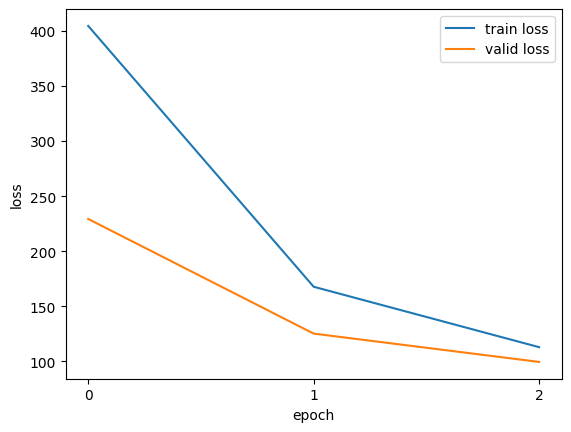

In [8]:
from spektral.data import BatchLoader
from utils.model import sync


loader_train = BatchLoader(train_data_total, batch_size=batch_size, shuffle=True)
loader_valid = BatchLoader(valid_data_total, batch_size=batch_size, shuffle=True)

best_epoch = 0
best_val_score = 1e10

# train model
loss_all = []
val_loss_all = []
for epoch in range(epochs):
	history = model_total.fit(loader_train.load(),
														validation_data=loader_valid.load(),
														steps_per_epoch=loader_train.steps_per_epoch,
														validation_steps=loader_valid.steps_per_epoch,
														epochs=1,
														shuffle=True)
	loss_all.append(history.history['loss'][0])
	val_loss_all.append(history.history['val_loss'][0])

	# save model every model_save_freq epochs
	# if (epoch + 1) % model_save_freq == 0:
	# 	model_total_save_path = os.path.join(dir_parmas, f'{model_name}_total_lr{lr}_batchsize{batch_size}_epochs{epoch}.h5')
	# 	model_total.save_weights(model_total_save_path)

	# save best model on validation set
	val_loss, val_score = model_total.evaluate(loader_valid.load(), steps=loader_valid.steps_per_epoch)
	if val_score < best_val_score:
		best_epoch = epoch
		best_val_score = val_score
		sync(model_total, model_best_total)

# save best model
model_total_save_path = os.path.join(dir_parmas, f'{model_name}_total_best_lr{lr}_batchsize{batch_size}_epochs{best_epoch}of{epochs}.h5')
model_best_total.save_weights(model_total_save_path)
model_total.summary()

# plot 
plt.plot(loss_all, label='train loss')
plt.plot(val_loss_all, label='valid loss')
plt.legend()
plt.xticks(range(epochs))
plt.xlabel('epoch')
plt.ylabel('loss')

# save picture
plt_save_path = os.path.join(os.getcwd(), f"../results/{model_name}_total_lr{lr}_batchsize{batch_size}_epochs{epochs}.jpg")
plt.savefig(plt_save_path)

#### 模型测试

In [9]:
from utils.analysis import gnn_analysis


yt_train = np.array([data.y for data in train_data_total]).reshape(-1, 1)
yt_valid = np.array([data.y for data in valid_data_total]).reshape(-1, 1)
yt_test = np.array([data.y for data in test_data_total]).reshape(-1, 1)
dict_total = gnn_analysis(model_total, batch_size, 
						  train_data_total, yt_train,
						  valid_data_total, yt_valid,
						  test_data_total, yt_test, name=model_name)
results_total = pd.Series(dict_total).to_frame(name='total').T

# save results
dir_results = os.path.abspath(os.path.join(os.getcwd(), "../results/"))
if not os.path.exists(dir_results):
		os.mkdir(dir_results)

results_total.to_csv(os.path.join(dir_results, f"{model_name}_total_lr{lr}_batchsize{batch_size}_epochs{epochs}.csv"), index=False)

8/8 [==============================] - 3s 372ms/step
gcn train mse: 689035.8
gcn train r2: -853343.071397829
gcn valid mse: 653024.4
gcn valid r2: -653746.4983320809
gcn test mse: 692421.6
gcn test r2: -708861.5514175302


gcn train analysis
min error: 63.32205
max error: 147.5197
mean error: 93.844025
std error: 18.04897
good ratio: 0.0
bad ratio: 1.0

gcn valid analysis
min error: 68.26279
max error: 140.1562
mean error: 89.81085
std error: 14.984162
good ratio: 0.0
bad ratio: 1.0

gcn test analysis
min error: 65.60631
max error: 138.1185
mean error: 93.522644
std error: 18.168652
good ratio: 0.0
bad ratio: 1.0



### 耦合电容模型

#### 模型训练

d:\learn_more_from_life\computer\EDA\work\prj\rc_predict\code\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


8/8 [==============================] - 3s 389ms/step - loss: 185.5509 - measure_ratio_good: 0.0000e+00
Model: "gcn_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gcn_conv_3 (GCNConv)        multiple                  96        
                                                                 
 diff_pool_2 (DiffPool)      multiple                  4352      
                                                                 
 gcn_conv_4 (GCNConv)        multiple                  272       
                                                                 
 diff_pool_3 (DiffPool)      multiple                  1280      
                                                                 
 gcn_conv_5 (GCNConv)        multiple                  272       
                                                                 
 global_avg_pool_1 (GlobalAv  multiple                 0         
 gPool)                 

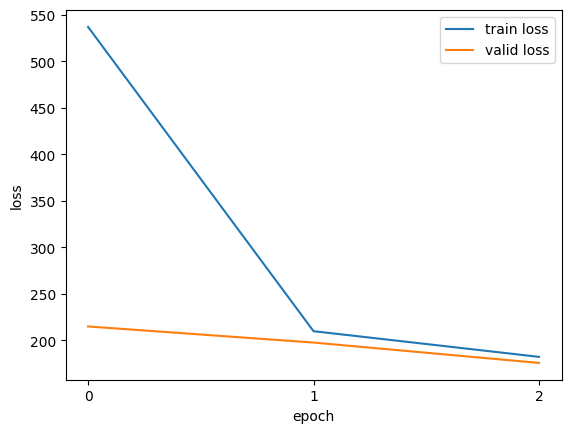

In [10]:
from spektral.data import BatchLoader
from utils.model import sync


loader_train = BatchLoader(train_data_couple, batch_size=batch_size, shuffle=True)
loader_valid = BatchLoader(valid_data_couple, batch_size=batch_size, shuffle=True)

best_epoch = 0
best_val_score = 1e10

# train model
loss_all = []
val_loss_all = []
for epoch in range(epochs):
	history = model_couple.fit(loader_train.load(),
														validation_data=loader_valid.load(),
														steps_per_epoch=loader_train.steps_per_epoch,
														validation_steps=loader_valid.steps_per_epoch,
														epochs=1,
														shuffle=True)
	loss_all.append(history.history['loss'][0])
	val_loss_all.append(history.history['val_loss'][0])

	# save model every model_save_freq epochs
	# if (epoch + 1) % model_save_freq == 0:
	# 	model_couple_save_path = os.path.join(dir_parmas, f'{model_name}_couple_lr{lr}_batchsize{batch_size}_epochs{epoch}.h5')
	# 	model_couple.save_weights(model_couple_save_path)

	# save best model on validation set
	val_loss, val_score = model_couple.evaluate(loader_valid.load(), steps=loader_valid.steps_per_epoch)
	if val_score < best_val_score:
		best_epoch = epoch
		best_val_score = val_score
		sync(model_couple, model_best_couple)

# save best model
model_couple_save_path = os.path.join(dir_parmas, f'{model_name}_couple_best_lr{lr}_batchsize{batch_size}_epochs{best_epoch}of{epochs}.h5')
model_best_couple.save_weights(model_couple_save_path)
model_couple.summary()

# plot 
plt.plot(loss_all, label='train loss')
plt.plot(val_loss_all, label='valid loss')
plt.legend()
plt.xticks(range(epochs))
plt.xlabel('epoch')
plt.ylabel('loss')

# save picture
plt_save_path = os.path.join(os.getcwd(), f"../results/{model_name}_couple_lr{lr}_batchsize{batch_size}_epochs{epochs}.jpg")
plt.savefig(plt_save_path)

#### 模型测试

In [11]:
from utils.analysis import gnn_analysis


yc_train = np.array([data.y for data in train_data_couple]).reshape(-1, 1)
yc_valid = np.array([data.y for data in valid_data_couple]).reshape(-1, 1)
yc_test = np.array([data.y for data in test_data_couple]).reshape(-1, 1)
dict_couple = gnn_analysis(model_couple, batch_size, 
						   train_data_couple, yc_train, 
						   valid_data_couple, yc_valid,
						   test_data_couple, yc_test, name=model_name)
results_couple = pd.Series(dict_couple).to_frame(name='couple').T

# save results
dir_results = os.path.abspath(os.path.join(os.getcwd(), "../results/"))
if not os.path.exists(dir_results):
	os.mkdir(dir_results)

results_couple.to_csv(os.path.join(dir_results, f"{model_name}_couple_lr{lr}_batchsize{batch_size}_epochs{epochs}.csv"), index=False)

8/8 [==============================] - 2s 307ms/step
gcn train mse: 1211478.5
gcn train r2: -1122869.1910474724
gcn valid mse: 1249999.9
gcn valid r2: -1096115.0186425936
gcn test mse: 1275977.6
gcn test r2: -1041272.3465665667


gcn train analysis
min error: 161.63043
max error: 469.99002
mean error: 290.8486
std error: 64.99368
good ratio: 0.0
bad ratio: 1.0

gcn valid analysis
min error: 168.57019
max error: 472.3643
mean error: 300.0161
std error: 74.890434
good ratio: 0.0
bad ratio: 1.0

gcn test analysis
min error: 173.56883
max error: 501.5898
mean error: 291.67743
std error: 68.409355
good ratio: 0.0
bad ratio: 1.0

